In [1]:
import keras
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import plotly.graph_objects as go
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

In [2]:
np.random.seed(1)
tf.random.set_seed(1)

In [3]:
df = pd.read_csv('wind-farm-1-signals-2016.csv', sep=';')
df = df[['Timestamp', 'Gen_RPM_Avg']]
# df['Date'] = pd.to_datetime(df['Date'])
df['Timestamp'].min(), df['Timestamp'].max()

('2016-01-01T00:00:00+00:00', '2016-12-31T23:50:00+00:00')

In [4]:
df.head()

,Timestamp,Gen_RPM_Avg
0,2016-01-08T23:10:00+00:00,1416.4
1,2016-04-19T12:20:00+00:00,1680.0
2,2016-01-08T23:10:00+00:00,1495.0
3,2016-04-19T12:30:00+00:00,1677.5
4,2016-01-08T23:50:00+00:00,1481.3


In [5]:
# fig = go.Figure()
# fig.add_trace(go.Scatter(x=df['Timestamp'], y=df['Gen_RPM_Avg']))
# fig.show()

In [6]:
train, test = df.loc[df['Timestamp'] <= '2016-09-01'], df.loc[df['Timestamp'] > '2016-09-01']
train.shape, test.shape

((138129, 2), (69776, 2))

In [7]:
scaler = StandardScaler()
scaler = scaler.fit(train[['Gen_RPM_Avg']])

train['Gen_RPM_Avg'] = scaler.transform(train[['Gen_RPM_Avg']])
test['Gen_RPM_Avg'] = scaler.transform(test[['Gen_RPM_Avg']])

<ipython-input-7-e2f253ed8aa7>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Gen_RPM_Avg'] = scaler.transform(train[['Gen_RPM_Avg']])
<ipython-input-7-e2f253ed8aa7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Gen_RPM_Avg'] = scaler.transform(test[['Gen_RPM_Avg']])


In [8]:
TIME_STEPS=30

def create_sequences(X, y, time_steps=TIME_STEPS):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        Xs.append(X.iloc[i:(i+time_steps)].values)
        ys.append(y.iloc[i+time_steps])
    
    return np.array(Xs), np.array(ys)

X_train, y_train = create_sequences(train[['Gen_RPM_Avg']], train['Gen_RPM_Avg'])
X_test, y_test = create_sequences(test[['Gen_RPM_Avg']], test['Gen_RPM_Avg'])

print(f'Training shape: {X_train.shape}')
print(f'Testing shape: {X_test.shape}')

Training shape: (138099, 30, 1)
Testing shape: (69746, 30, 1)


In [9]:
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(rate=0.2))
model.add(RepeatVector(X_train.shape[1]))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(X_train.shape[2])))
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 repeat_vector (RepeatVector  (None, 30, 128)          0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 30, 128)           131584    
                                                                 
 dropout_1 (Dropout)         (None, 30, 128)           0         
                                                                 
 time_distributed (TimeDistr  (None, 30, 1)            129       
 ibuted)                                                

In [10]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')], shuffle=False)

Epoch 1/10
3885/3885 [==============================] - 275s 67ms/step - loss: 0.6889 - val_loss: 0.7201
Epoch 2/10
3885/3885 [==============================] - 220s 57ms/step - loss: 0.6740 - val_loss: 0.7155
Epoch 3/10
3885/3885 [==============================] - 216s 55ms/step - loss: 0.6703 - val_loss: 0.7149
Epoch 4/10
3885/3885 [==============================] - 217s 56ms/step - loss: 0.6685 - val_loss: 0.7136
Epoch 5/10
3885/3885 [==============================] - 218s 56ms/step - loss: 0.6674 - val_loss: 0.7134
Epoch 6/10
3885/3885 [==============================] - 208s 54ms/step - loss: 0.6666 - val_loss: 0.7134
Epoch 7/10
3885/3885 [==============================] - 205s 53ms/step - loss: 0.6659 - val_loss: 0.7131
Epoch 8/10
3885/3885 [==============================] - 212s 55ms/step - loss: 0.6653 - val_loss: 0.7129
Epoch 9/10
3885/3885 [==============================] - 214s 55ms/step - loss: 0.6649 - val_loss: 0.7125
Epoch 10/10
3885/3885 [==============================] 

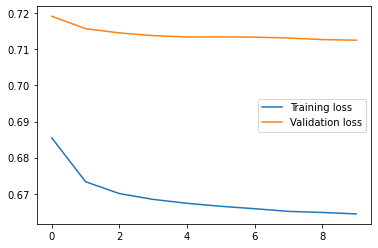

In [26]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend();

In [2]:
accuracy = model.evaluate(X_test, y_test)
print(accuracy)

NameError: name 'model' is not defined

Reconstruction error threshold: 1.8215774553272348


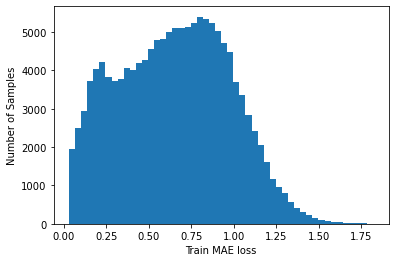

In [28]:
X_train_pred = model.predict(X_train, verbose=0)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples');

threshold = np.max(train_mae_loss)
print(f'Reconstruction error threshold: {threshold}')

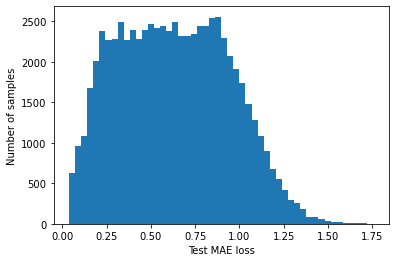

In [29]:
X_test_pred = model.predict(X_test, verbose=0)
test_mae_loss = np.mean(np.abs(X_test_pred-X_test), axis=1)

plt.hist(test_mae_loss, bins=50)
plt.xlabel('Test MAE loss')
plt.ylabel('Number of samples');

In [31]:
test_score_df = pd.DataFrame(test[TIME_STEPS:])
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = threshold
test_score_df['anomaly'] = test_score_df['loss'] > test_score_df['threshold']
test_score_df['Gen_RPM_Avg'] = test[TIME_STEPS:]['Gen_RPM_Avg']

fig = go.Figure()
fig.add_trace(go.Scatter(x=test_score_df.iloc[0:500]['Timestamp'], y=test_score_df['loss'], name='Test loss'))
fig.add_trace(go.Scatter(x=test_score_df.iloc[0:500]['Timestamp'], y=test_score_df['threshold'], name='Threshold'))
fig.update_layout(showlegend=True, title='Test loss vs. Threshold')
fig.show()

In [32]:
anomalies = test_score_df.loc[test_score_df['anomaly'] == True]
anomalies.shape

(0, 5)

In [34]:
# fig = go.Figure()
# fig.add_trace(go.Scatter(x=test_score_df['Timestamp'], y=scaler.inverse_transform(test_score_df['Gen_RPM_Avg']), name='Generator'))
# fig.add_trace(go.Scatter(x=anomalies['Timestamp'], y=scaler.inverse_transform(anomalies['Gen_RPM_Avg']), mode='markers', name='Anomaly'))
# fig.update_layout(showlegend=True, title='Detected anomalies')
# fig.show()